## Building A Classifier to Predict NC Seasons

In [18]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import itertools
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

In [19]:
def divide_data(rent):
    '''divide dataset into two sets: 90% test/train and 10% validation'''
    n = rent.shape[0]
    
    # take out 10% of the data for validation
    ind_valid = np.random.choice(n, size = n // 10, replace = False) # [6]
    rent_valid = rent.iloc[ind_valid]

    # take the other 90% for building the model
    ind_tt = [x for x in range(n) if x not in ind_valid] # not in index [7]
    rent_tt = rent.iloc[ind_tt]

    # shuffle data for test/train so no patterns in folds [8]
    rent_tt = shuffle(rent_tt)

    return rent_valid, rent_tt

def classification_mse(class_truth, pred_class):
    '''compute classification mse'''
    return np.mean(class_truth != pred_class)

def cross_validation(data, method, k):    
    '''k-fold cross-validation'''
    # calculate fold divisions
    n = data.shape[0]
    n_predictors = data.shape[1] - 1
    foldSize =  n // k # int divide
    foldDivisions = [foldSize * x for x in range(k+1)]

    # adjust for uneven fold size
    if n % k != 0: 
        r = n % k # remainder
        for i in range(1, k+1):
            # add 1 + previous size increase to each group until r
            # then just shift by r to account for previous size increases
            foldDivisions[i] += min(i, r)

    # divide into folds
    folds = []
    for i in range(k):
        folds.append(data.iloc[foldDivisions[i]:foldDivisions[i+1], :])

    # linear model w/ each fold as test once
    test_errors = []

    for i in range(k):
        # get test fold
        test = folds[i]

        # combine other folds into training set
        train_folds = folds.copy()
        train_folds.pop(i)
        train = pd.concat(train_folds) # concatenate folds [9]

        if method == 'SVM':
            # fit SVM to training data
            mod = SVC(kernel="rbf")
        elif method == 'neighbor':
            # fit SVM to training data
            mod = KNeighborsClassifier(n_neighbors = 9)
        elif method == 'tree':
            # fit decision tree to training data
            mod = DecisionTreeClassifier()
        elif method == 'forest':
            # build random forest classifier for training data
            mod = RandomForestClassifier(n_estimators=10, max_features = min(3, n_predictors), max_depth=3, random_state=0)
        
        mod.fit(train.iloc[:,:-1], train.iloc[:,-1]) # class var in last column
        
        # compute testing error
        test_preds = mod.predict(test.iloc[:,:-1])
        test_error = classification_mse(test_preds, test.iloc[:,-1])
        test_errors.append(test_error)

    # cross validation error - avg of test errors
    cross_val_error = np.mean(test_errors)
    
    return cross_val_error

def all_cv_errors(rent_tt, methods):
    '''get cross-validation error for all possible models'''
    cv_errors = []     
    # test each possible model type
    for method in methods:
        # compute cross-validation error
        cv_err = cross_validation(rent_tt, method, 10)

        # store errors
        cv_errors.append([method, cv_err])
                
    # sort cv errors w/ lowest in first row
    cv_err_np = np.array(cv_errors, dtype=object)
    cv_err_np = cv_err_np[np.argsort(cv_err_np[:,1])]
    return cv_err_np

In [20]:
# TODO: Make .py for importing standardize()?
def standardize(data):
    '''Standardize a dataframe'''
    mean_vec = np.mean(data, axis=0)
    sd_vec = np.std(data, axis=0)

    data_std = data.copy()
    for i in range(data.shape[1]): # for every column
        data_std[:,i] = (data[:,i] - mean_vec[i]*np.ones(data.shape[0]))/sd_vec[i]
        
    return data_std

In [21]:
# import data
weather_pd = pd.read_csv('../data/weather.csv', index_col = 0)
weather_pd = weather_pd.drop(['YEAR', 'DAY', 'STP', 'GUST'], axis=1) # remove faulty columns and some temporal indicators

# drop station pressure bc redundant with sea level and not collected in 2000, 2002, 2004
# and drop max gust because missing for half the days and somewhat redundant w/ mxspd

In [22]:
# move seasons (classes) to last column
columns = list(weather_pd.columns)
columns.remove('SEASON')
columns.append('SEASON')
weather_pd = weather_pd[columns]

In [23]:
weather_pd.head()

,MONTH,TEMP,DEWP,SLP,VISIB,WDSP,MXSPD,MAX,MIN,PRCP,SNDP,SEASON
0,1,47.6,38.1,1023.7,8.3,3.0,10.1,66.9,33.1,0.00,0.0,0
1,1,55.3,46.3,1024.2,9.5,4.8,14.0,70.0,33.1,0.00,0.0,0
2,1,62.6,55.4,1021.3,8.4,8.5,14.0,73.9,43.0,0.00,0.0,0
3,1,65.2,58.6,1014.4,9.5,15.3,28.0,73.9,55.0,0.00,0.0,0
4,1,45.7,30.9,1019.8,9.8,6.4,11.1,57.9,37.0,0.34,0.0,0


## Divide into Test/Train and Validation

In [26]:
# separate data into test/train and validation sets
np.random.seed(888)
weather_valid, weather_tt = divide_data(weather_pd)

## Cross-Validation for Model Selection

In [27]:
# get all cv errors for all combos of predictor features
# for each method
cv_errors = all_cv_errors(weather_tt, ['neighbor', 'tree', 'forest']) # excluding 'SVM'

# store best combo of features
best_method = cv_errors[0,0]
lowest_cv_err = cv_errors[0,1]

In [31]:
# print best model
print('best model')
print('method:  ', best_method)
print('error:   ', lowest_cv_err)

best model
method:   tree
error:    0.13524054772123442


## Build Model

In [32]:
# build model from best features 
dt = DecisionTreeClassifier()
dt.fit(weather_tt.iloc[:,:-1], weather_tt.iloc[:,-1])

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

## Validate Model

In [33]:
# compute validation error
val_preds = dt.predict(weather_valid.iloc[:,:-1])
val_error = classification_mse(val_preds, weather_valid.iloc[:,-1])

In [34]:
print('validation error:           ', val_error)
print('best cross-validation error:', lowest_cv_err)

validation error:            0.11325611325611326
best cross-validation error: 0.13524054772123442


## Plot Validation Predicted Classes in 2D

In [39]:
# convert to numpy and remove class column
valid_np = weather_valid.to_numpy()[:, :-1]
valid_std = standardize(valid_np)

In [40]:
# (for plotting)
pca = PCA(n_components=2)
valid_two = pca.fit_transform(valid_std)

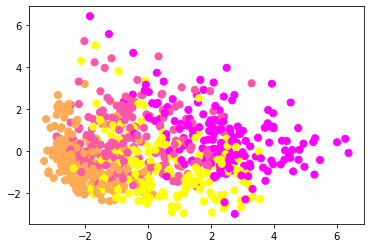

In [41]:
plt.scatter(valid_two[:,0], valid_two[:,1], c=val_preds, s=50, cmap="spring")